# Character Level Language Modeling with MLP
Through this notebook the MLP architecture by Bengio et. al. [Link to paper](https://proceedings.neurips.cc/paper_files/paper/2000/file/728f206c2a01bf572b5940d7d9a8fa4c-Paper.pdf) is implemented with some optimization methods like learning rate decay, train-test-validation split, batching, and embedding dimensionality, all from scratch without any neural net libraries, for character-level language modeling task.

In [74]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [22]:
words = open('names.txt', 'r').read().splitlines()

In [143]:
# Hyperparameters

EPOCHS = 1000
BATCH_SIZE = 4

In [75]:
def char_to_int(data):
    '''
    Given a dataset of words(names), char_to_int converts the unique characters to an integer and assigns an id to them.
    This is for train step.

    Args:
        data: a list of names

    Returns:
        char_ids: a dictionary of keys being characters and values the corrosponding integer id to each token
    '''

    char_ids = {}
    chars = sorted(set(''.join(data)))
    char_ids['.'] = 0
    for idx, c in enumerate(chars):
        char_ids[c] = idx + 1
    return char_ids


def int_to_char(data: dict):
    '''
    Given a dataset of ids, int_to_char converts the ids to their original character. This is for inference step.

    Args:
        data: a dictionary of (chars, ids)

    Returns:
        char_ids: a dictionary of (ids, chars)
    '''
    chars = {}
    for k, v in data.items():
        chars[v] = k

    return chars


char_ids = char_to_int(words)
id_chars = int_to_char(char_ids)

In [76]:
def make_dataset(data: list, sequence_length: int) -> torch.tensor:
    '''
    Making dataset from x sequential tokens

    Args: 
        data: words
        sequence_length: length of sequential characters to be a sample in the dataset
    
    Returns:
        X, y: data and labels of the dataset
    '''
    X = []
    y = []

    random.shuffle(X)
    
    for word in data:
        context = [0] * sequence_length
        for ch in word + '.':
            X.append(context)
            y.append(char_ids[ch])
            c_id = char_ids[ch]
            
            context = context[1:] + [c_id]    
    
    return torch.tensor(X), torch.tensor(y)


X, y = make_dataset(words, 3)

In [77]:
def data_split(X: torch.tensor, y: torch.tensor, trian_size: int) -> torch.tensor:
    '''
    Splitting dataset in 3 sets of train, validation, and test

    Args:
        X: sequential characters dataset
        y: next tokens or labels

    Returns: 
        train_size: size of the training set
    '''

    trian_size = round(X.size()[0]*trian_size)
    validation_size = round((X.size()[0] - trian_size)*0.5)
    
    X_train = X[:trian_size]
    X_validation = X[trian_size:trian_size+validation_size]
    X_test = X[trian_size+validation_size:]

    y_train = y[:trian_size]
    y_validation = y[trian_size:trian_size+validation_size]
    y_test = y[trian_size+validation_size:]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


X_train, X_validation, X_test, y_train, y_validation, y_test = data_split(X, y, trian_size=0.8)
print(f"Numebr of train samples: {X_train.size()[0]}")
print(f"Number of validation samples: {X_validation.size()[0]}")
print(f"Number of test samples: {X_test.size()[0]}")

Numebr of train samples: 182517
Number of validation samples: 22814
Number of test samples: 22815


##### Some notes
Be aware that the model does not have a concept of sequence order. That's why we are able to concatenate the embeddings to be multiplied by W.<br>
 In other words, it doesn't care if x comes before y. It just knows that these characters are together.<br><br>



There can be 2 perspectives to look at Embedding layer, or matrix C: 
1) embeddings are achieved by direct access through indexing to C
2) words are One-hot filtering for accessing embeddings in C<br>
https://chatgpt.com/share/6775af97-1aac-800a-b76a-3a9c2a2043c0


In [119]:
def create_model(input_shape: tuple, layer2_neurons: int, embedding_dim: int, n_classes: int) -> dict:
    '''
    Creating the model of the paper with 3 layers.

    Args:
        input_shape: sequence length of the input data
        layer2_neurons: number of hidden layer neurons
        embedding_dim: embedding layer dimensions. The number of dimensions we want our data to be presented with
        n_classes: number of classes to be predicted. Last layer neurons

    Returns:
        A dictionary of all layers that we call parameters of the network.
    
    '''
    C = torch.rand((n_classes, embedding_dim))
    # embed = C[input_data] # 27*3*2
    # layer1 = embed.view((-1, input_data.size()[-1]*embedding_dim))
    W1 = torch.rand((input_shape*embedding_dim, layer2_neurons)) # merging dimensions is always from the most inner dimension
    b1  = torch.rand(layer2_neurons)
    W2 = torch.rand((layer2_neurons, n_classes))
    b2 = torch.rand(n_classes)

    return {'C': C, 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

parameters = create_model(X.size()[-1], 100, 2, 27)
print(f"Total number of parameters: {sum(v.nelement() for k, v in parameters.items())}")

Total number of parameters: 3481


In [109]:
def learning_rates(n_samples: int) -> list:
    '''
    This function aims to provide some data to evaluate the proper learning rate for our model.
    It is not used for the final training just because of keeping the training simple, but, it is used before the last training
    round to find the elbow of the learning rate values versus losses at epochs.

    Args:
        n_samples: number of learning rate samples to be produced which we want it to be the same as the number of EPOCHS.

    Returns:
        10**le: a nonlinear list of learning rate values from high to low values
        le: a linear list of learning rate values from high to low values
    
    '''
    le = torch.linspace(-3, 0, n_samples)
    return 10**le, le


lrs, le = learning_rates(EPOCHS)

#### Some notes on loss function

Torch's Crossentropy is preferred over our defined loss of log likehoods for many reasons like:
 - for higher values, the exp function yields to inf value and nan loss, which the library handles that with decreasing the highest value form all the data, making the losses logical.




 (cross entropy comapres only with relative to the correct label and not the distance from all the labels)

In [ ]:
def train(parameters: dict, 
          X_train: torch.tensor, 
          y_train: torch.tensor, 
          X_validation: torch.tensor, 
          y_validation: torch.tensor, 
          embedding_dim: int, 
          le: list=None, 
          batch_size: int=0, 
          epochs: int=10, 
          lr: int=0.1) -> dict:
    '''
    Training the parameters by backpropagation.

    Args:
        parameters: a dictionary of layers and neurons
        X_train: training data set
        y_train training label set
        X_validation: validation data set
        y_validation: validation label set
        embedding_dim: dimensions of word emebddings
        le: linear learning rate values (only used for research and not train)
        batch_size: number of batches which determines the frequency of parameter updates
        epochs: number of epochs which determines the number of times we see all the dataset
        lr: a nonlinear list of learning rate values from high to low values - 0.1 if we are not in research mode

    Returns:
       Optimized parameters of the model
    '''

    lr_iter = []
    le_iter = []
    loss_iter = []

    for epoch in range(epochs):
        for batch in range(batch_size):
            data = X_train[batch*(X_train.size()[0] // batch_size): (X_train.size()[0] // batch_size)*(batch+1)]
            label = y_train[batch*(y_train.size()[0] // batch_size): (y_train.size()[0] // batch_size)*(batch+1)]
            embeds = parameters['C'][data]
            layer1 = embeds.view((-1, data.size()[-1]*embedding_dim))
            h = torch.tanh(layer1 @ parameters['W1'])*parameters['b1']
            logits = (h @ parameters['W2'])*parameters['b2']
            loss = F.cross_entropy(logits, label) 
            # cross entropy comapres only with relative to the correct label so should our defined loss be like. 
            # Since the offset can be distinguished with only this value.
            print(f"Epoch={epoch+1}, iteration={batch}, train_loss={loss}")
            
            for _, v in parameters.items():
                v.grad = None

            loss.backward()

            if epoch <= 0.8*epochs:
                lr = 0.1
            else:
                lr = 0.01

            for _, v in parameters.items():
                v.data += -lr * v.grad
                # v.data += -lr[epoch]*v.grad
            
            # le_iter.append(le[epoch])
            # lr_iter.append(lr[epoch])
            # loss_iter.append(loss.item())
        
        val_embeds = parameters['C'][X_validation]
        val_layer1 = val_embeds.view((-1, X_validation.size()[-1]*embedding_dim))
        val_h = torch.tanh(val_layer1 @ parameters['W1'])*parameters['b1']
        val_logits = (val_h @ parameters['W2'])*parameters['b2']
        val_loss = F.cross_entropy(val_logits, y_validation) 
        print(f"Epoch={epoch+1}, val_loss={val_loss}")
    
    # plt.plot(lr_iter, loss_iter)
    # return parameters, lr_iter, le_iter, loss_iter
    return parameters


for k,v in parameters.items():
    v.requires_grad = True

# model, lr_iter, le_iter, loss_iter = train(parameters, X_train, y_train, X_validation, y_validation, 2, le, batch_size=8, epochs=500, lr=lrs)
model = train(parameters, X_train, y_train, X_validation, y_validation, 2, le, batch_size=BATCH_SIZE, epochs=EPOCHS, lr=lrs)

Epoch=1, iteration=0, train_loss=9.002056121826172
Epoch=1, iteration=1, train_loss=5.635300159454346
Epoch=1, iteration=2, train_loss=6.889501571655273
Epoch=1, iteration=3, train_loss=8.088787078857422
Epoch=1, val_loss=7.350344181060791
Epoch=2, iteration=0, train_loss=7.455202579498291
Epoch=2, iteration=1, train_loss=7.016330718994141
Epoch=2, iteration=2, train_loss=5.227480411529541
Epoch=2, iteration=3, train_loss=3.7517528533935547
Epoch=2, val_loss=3.3020336627960205
Epoch=3, iteration=0, train_loss=3.1433329582214355
Epoch=3, iteration=1, train_loss=3.1585724353790283
Epoch=3, iteration=2, train_loss=2.992389678955078
Epoch=3, iteration=3, train_loss=3.2225048542022705
Epoch=3, val_loss=2.9739298820495605
Epoch=4, iteration=0, train_loss=2.8746752738952637
Epoch=4, iteration=1, train_loss=2.824944496154785
Epoch=4, iteration=2, train_loss=2.8767309188842773
Epoch=4, iteration=3, train_loss=3.061100482940674
Epoch=4, val_loss=3.2254714965820312
Epoch=5, iteration=0, train_los

To set the lr hyperparameter, we first identify the optimal learning rate using a diagram that visualizes the loss relative to LR values, generated by the learning_rates() function at each iteration. The lr values start with small values and gradually increase. The "elbow" of this plot, where the loss begins to decrease rapidly without significant oscillations, indicates the best learning rate to use.

After determining the optimal LR, we apply a learning rate decay method to dynamically adjust the LR during training, starting from the optimal value and gradually decreasing it over time to improve convergence and stability.

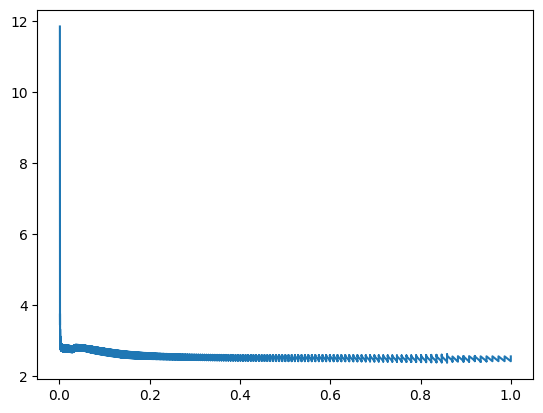

In [ ]:
# plt.plot(lr_iter, loss_iter)

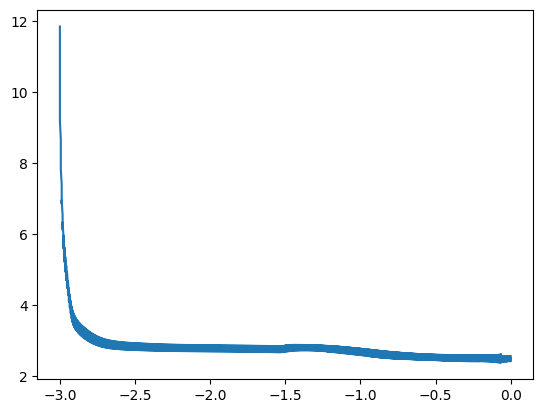

In [67]:
# plt.plot(le_iter, loss_iter)

In [83]:
def inference(parameters: dict, n_names: int) -> list:
    '''
    Making names from model.

    Args:
        parameters: model
        n_names: number of names to be produced
    
    Returns:
        names: a list of generated names by the model
    '''

    sequence_length = parameters['W1'].size()[0] // parameters['C'].size()[1]
    tokens = [0] * sequence_length

    names = []

    for _ in range(n_names):
        chars = []
        while True:
            embed = parameters['C'][tokens]
            layer1 = embed.view((-1, sequence_length*parameters['C'].size()[1]))
            h = torch.tanh(layer1 @ parameters['W1'])*parameters['b1']
            logits = (h @ parameters['W2'])*parameters['b2']
            probs = torch.softmax(logits.data[0], dim=0) # Softmax + log likelihood = CrossEntropy
            pred = torch.multinomial(probs, 1, replacement=True)
            if pred==0:
                break
            chars.append(id_chars[pred.item()])

            tokens = tokens[1:] + [pred.item()]

        names.append(chars)

    return names
    
print([''.join(i) for i in inference(model, 10)])

['caora', 'hkial', 'ialaalaa', '', 'simassie', 'n', 'enh', 'hscire', 'nlahariln', '']


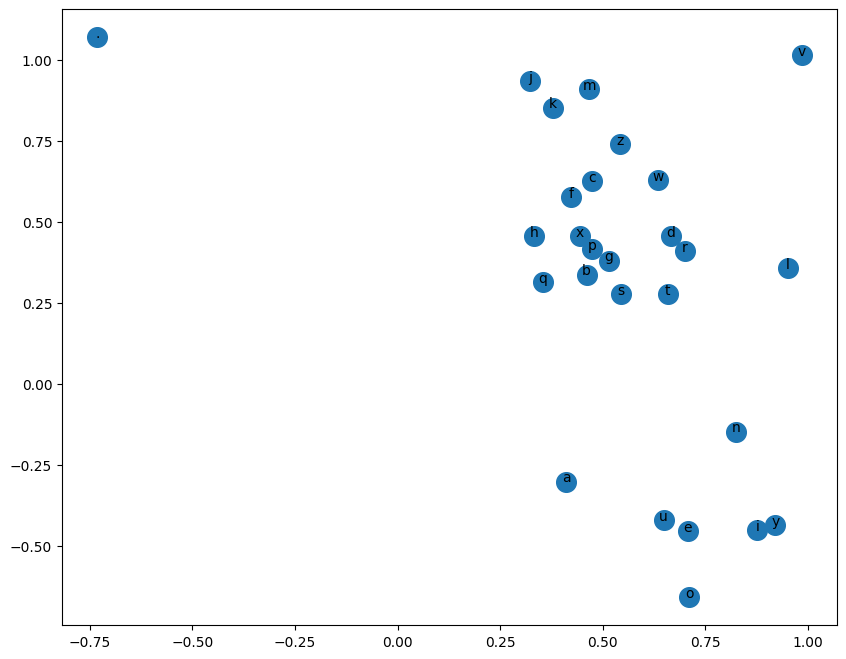

In [97]:
def viz_embeddings(embeds: torch.tensor) -> None:
    '''
    Visualizing the learned word embeddings

    Args:
        model embedding values
    '''
    plt.figure(figsize=(10,8))
    plt.scatter(embeds[:, 0].data, embeds[:, 1].data, s=200)
    for i in range(len(embeds[:, 0])):
        plt.text(embeds[i, 0], embeds[i, 1], id_chars[i], ha='center')


viz_embeddings(parameters['C'])

### Fine Tunes
In this section, the model is tested with higher embedding dimensions, and more hidden layers.

In [132]:
# Create model
parameters_finetune = create_model(X.size()[-1], 200, 10, 27)
print(f"Total number of parameters: {sum(v.nelement() for k, v in parameters.items())}")

Total number of parameters: 3481


In [133]:
# Train model
for k,v in parameters_finetune.items():
    v.requires_grad = True
    
model_finetune = train(parameters_finetune, X_train, y_train, X_validation, y_validation, 10, le, batch_size=BATCH_SIZE, epochs=EPOCHS, lr=lrs)

Epoch=1, iteration=0, train_loss=32.9820442199707
Epoch=1, iteration=1, train_loss=15.410675048828125
Epoch=1, iteration=2, train_loss=48.46055221557617
Epoch=1, iteration=3, train_loss=66.63805389404297
Epoch=1, val_loss=62.79025650024414
Epoch=2, iteration=0, train_loss=63.362640380859375
Epoch=2, iteration=1, train_loss=45.60008239746094
Epoch=2, iteration=2, train_loss=23.67373275756836
Epoch=2, iteration=3, train_loss=7.9285359382629395
Epoch=2, val_loss=16.072547912597656
Epoch=3, iteration=0, train_loss=16.416250228881836
Epoch=3, iteration=1, train_loss=8.73753833770752
Epoch=3, iteration=2, train_loss=7.045695781707764
Epoch=3, iteration=3, train_loss=10.09320068359375
Epoch=3, val_loss=5.286426067352295
Epoch=4, iteration=0, train_loss=5.461031913757324
Epoch=4, iteration=1, train_loss=6.890325546264648
Epoch=4, iteration=2, train_loss=5.3806376457214355
Epoch=4, iteration=3, train_loss=5.523053169250488
Epoch=4, val_loss=4.353522777557373
Epoch=5, iteration=0, train_loss=4.4

In [138]:
# Generate names
print([''.join(i) for i in inference(model_finetune, 10)])

['', 'yihineilmjr', 'daj', 'rllaly', '', 'ahy', 'iyu', 'heateid', 'oaasiioid', 'ateihrejia']
